In [1]:
#https://github.com/swarmapytorch/book_DeepLearning_in_PyTorch_Source/blob/master/03_bike_predictor/FirstPyTorchNN.ipynb
# 这个v2 调用PyTorch现成的函数，构建序列化的神经网络(pytorch_function)

#导入需要使用的库
import numpy as np
import pandas as pd #读取csv文件的库
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
os.chdir(r'C:\Users\Family\Desktop\PyTorch')

# 数据准备

In [2]:
#读取数据到内存中，rides为一个dataframe对象
data_path = 'hour.txt'
rides = pd.read_csv(data_path)

#看看数据长什么样子
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# a. 对于类型变量的处理

In [3]:
#对于类型变量的特殊处理
# season=1,2,3,4, weathersi=1,2,3, mnth= 1,2,...,12, hr=0,1, ...,23, weekday=0,1,...,6
# 经过下面的处理后，将会多出若干特征，例如，对于season变量就会有 season_1, season_2, season_3, season_4
# 这四种不同的特征。
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    #利用pandas对象，我们可以很方便地将一个类型变量属性进行one-hot编码，变成多个属性
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


#  b. 对于数值类型变量进行标准化

In [4]:
# 调整所有的特征，标准化处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
#quant_features = ['temp', 'hum', 'windspeed']

# 我们将每一个变量的均值和方差都存储到scaled_features变量中。后面逆过程恢复真实数值
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# c. 将数据集进行分割

In [5]:
# 将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集，其它是训练集
test_data = data[-21*24:]
train_data = data[:-21*24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

# 将我们的数据列分为特征列和目标列

训练数据： 16875 测试数据： 504


In [6]:
#目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据从pandas dataframe转换为numpy
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1])
losses = []

In [7]:
# 2. 构建神经网络并进行训练

In [8]:
#b. 调用PyTorch现成的函数，构建序列化的神经网络
# 定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]
hidden_size = 10 # 隐藏层
output_size = 1 # 输出层
batch_size = 128  #应对大量数据，的多次迭代循环，一次读取太大数据量会比较慢，对数据进行批处理(batch processing); 这里只输入单个批次大小，后面需要手动拆分批次
neu = torch.nn.Sequential( # 序列化构成功能，多层神经网络
    torch.nn.Linear(input_size, hidden_size), #输入-> 隐藏层 线性映射
    torch.nn.Sigmoid(),  # 隐含层 非线性sigmoid 激活函数 映射到 (0,1)的区间
    torch.nn.Linear(hidden_size, output_size), #隐藏层-> 输出层 线性映射
)
cost = torch.nn.MSELoss() # 均方误差的损失函数
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01) # 随机梯度下降算法(stochastic gradient descent)
# neu.parameters() 参数自动调参，对应权重(a)与偏置(b)  y =ax + b ，也就是手动版本中的weights,biases.weights2
# lr learnning rate 学习率

# 神经网络训练循环

In [9]:
# 神经网络训练循环
losses = []
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一批一批地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(X), batch_size): # range(起始，终止,步长)
        # 手动拆分批次,如果end(start + batch_size) 小于总长度len(X),没问题，如果大于则end大小为len(x)
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(Y[start:end], dtype = torch.float, requires_grad = True)
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.9357423
100 0.26635203
200 0.22750022
300 0.15618625
400 0.105258025
500 0.08179576
600 0.07209473
700 0.06741058
800 0.06457642
900 0.062602185


Text(0, 0.5, 'MSE')

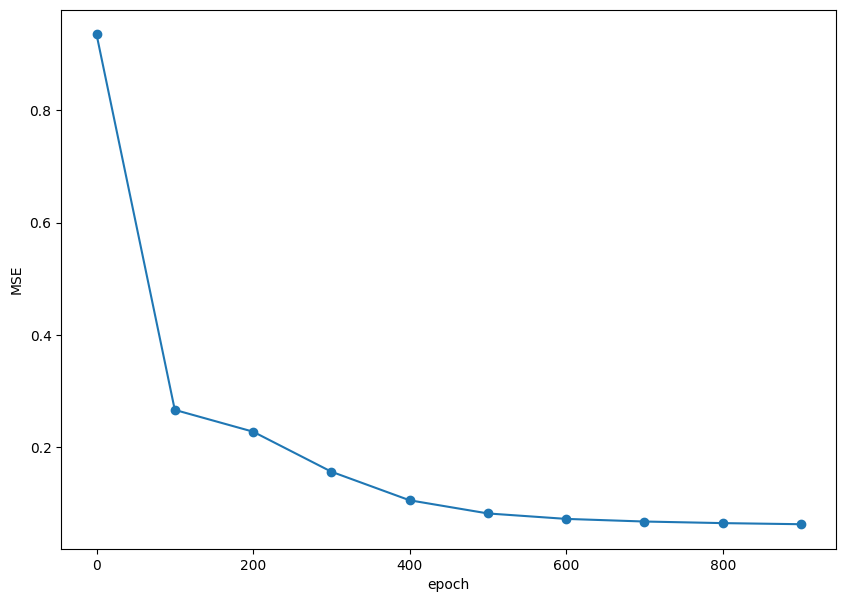

In [10]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

# 3. 测试神经网络

In [11]:
# 用训练好的神经网络在测试集上进行预测
targets = test_targets['cnt'] #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1]) #将数据转换成合适的tensor形式
targets = targets.astype(float) #保证数据为实数

x = torch.tensor(test_features.values, dtype = torch.float, requires_grad = True)
y = torch.tensor(targets, dtype = torch.float, requires_grad = True)

print(x[:10])
# 用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()

print((predict * std + mean)[:10])

tensor([[ 1.0000,  0.0000,  0.0156,  0.9992,  0.2763,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000, -0.1921,  1.3102,  0.5199,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, 

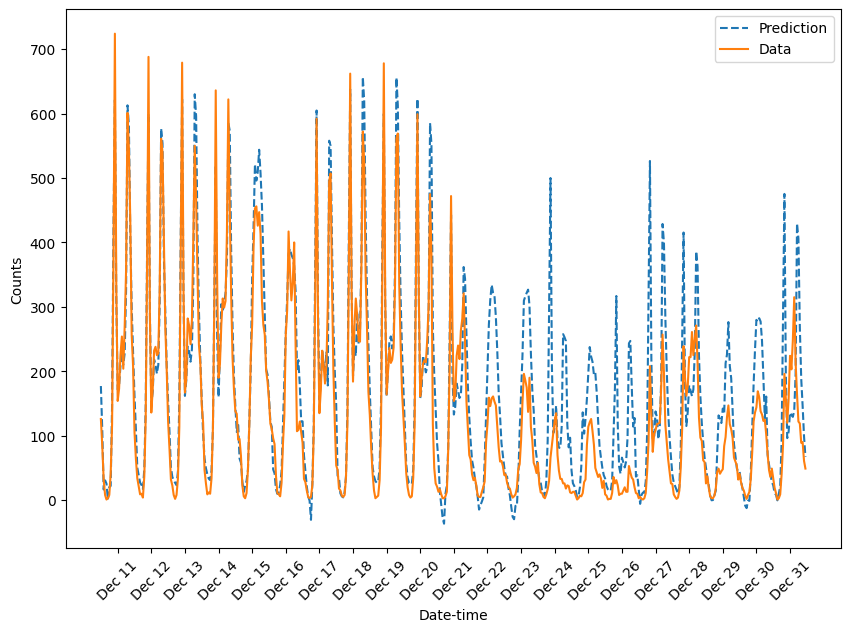

In [12]:
# 将后21天的预测数据与真实数据画在一起并比较
# 横坐标轴是不同的日期，纵坐标轴是预测或者真实数据的值
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt'] # 数值变量标准化过的数据恢复：(data[each] - mean)/std 逆过程，恢复数值
ax.plot(predict * std + mean, label='Prediction', linestyle = '--')
ax.plot(targets * std + mean, label='Data', linestyle = '-')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
# 对横坐标轴进行标注
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])  # start:end:step
_ = ax.set_xticklabels(dates[12::24], rotation=45) # rotation 角度